#### MPO 762 - Problem Set 5
#### Tiago Carrilho Bilo 
#### C\# 11950866


# The energy conserving discrete equation 

Model: 2D Inviscid non-linear shallow water equations on a Arakawa C-grid

$$\frac{\partial u_{i \pm \frac{1}{2},j}}{\partial t} - \overline{q \overline{V}^{x}}^{y} + \delta_{x} \Phi_{i \pm \frac{1}{2},j} = 0$$

$$\frac{\partial v_{i,j \pm \frac{1}{2}}}{\partial t} + \overline{q \overline{U}^{y}}^{x}  + \delta_{y} \Phi_{i,j \pm \frac{1}{2}} = 0$$

$$\frac{\partial \eta_{i,j}}{\partial t} + \delta_{x} U_{i,j} + \delta_{y} V_{i,j} = 0$$

where: 

* $(\delta_{x},\delta_{y}) =$ centered difference partial derivatives in x and y; 

* $U_{i\pm \frac{1}{2},j} = \overline{h}^{x}_{i \pm \frac{1}{2},j} \times u_{i \pm \frac{1}{2},j}$  mass flux through the x-face of the grid cell;

* $V_{i,j \pm \frac{1}{2}} = \overline{h}^{y}_{i,j \pm \frac{1}{2}} \times v_{i,j \pm \frac{1}{2}}$  mass flux through the y-face of the grid cell;

* $\Phi_{i,j} = g \eta_{i,j} + \frac{\overline{u^{2}}^{x} + \overline{v^{2}}^{y}}{2}$ total head;

* $q_{i\pm \frac{1}{2},j\pm \frac{1}{2}} = \frac{\delta_{x}v - \delta_{y}u + f}{\overline{h}^{xy}}$ potential vorticity.


** The model will be integrated using a RK3 time stepping scheme according to the adapted routines (nl_isw_2d_cp.m, rk3_isw.m, rhs_isw_continuity.m, rhs_isw_umomentum.m, and rhs_isw_vmomentum.m)**


# Equatorial Rossby Wave solution

Assuming a initial condition of an Equatorial Rossby Wave soliton of the form: 


$$u = \frac{6y^{2}-9}{4} \phi(x) e^{-\frac{y^{2}}{2}}$$

$$v = 2y \frac{d \phi}{d x} e^{-\frac{y^{2}}{2}} $$

$$\eta = \frac{6y^{2}+3}{4} \phi(x) e^{-\frac{y^{2}}{2}}$$


where: 

* $\phi (x) = 0.771 \times B^{2} \times sech^{2}(Bx)$;

* $\frac{d \phi}{d x} = −2B \times tanh(Bx) \times \phi$;

* $B = 0.395$

In [1]:
% Clear memory and close all figures
clear all 
close all 


% Model parameters (dimensionless)
H = 1.0;                          % Cte depth
g = 1.0;                          % Acceleration due to gravity
alpha = 1.0;                      % alpha = 1 = Include non-linear terms

B = 0.395;                        % Initial condition parameter

dt = 0.02;                        % Time step
dx = [0.5,0.25,0.125];            % zonal resolution
dy = dx;                          % meridional resolution

ts = [10:10:40];                  % Save solutions time-steps 

% Channel limits
xlim = [-24.0,24.0];               
ylim = [-8.0,8.0];

**Note on the time step ($\Delta t$):** In order to obtain a stable integration scheme (i. e., match of the spatial discretization stability region within the time-stepping scheme's) we have to adjust the time-step according to the spatial resolution. In our case, the dimensioneless  $\Delta t = 0.02$ will be stable for all proposed $\Delta x = \Delta y$.

### Numerical experiments 

In [2]:
% Run the 2D-Inviscid non-linear Shallow Water Model
% in a closed rectangular basin described by a Arakawa C-grid
% 
% The model integration is done by calling nl_isw_2d_cp.m
for i = [1:length(dx)]

    % Grid cells and grid cell edges - Grid set-up
    [x,xe,Nx] = FDGrid(xlim(1),xlim(2),dx(i)); 
    [y,ye,Ny] = FDGrid(ylim(1),ylim(2),dy(i));

    [x_eta,y_eta] = meshgrid(x,y);      % eta,H grid points
    [x_u,y_u] = meshgrid(xe,y);         % u,U   grid points
    [x_v,y_v] = meshgrid(x,ye);         % v,V   grid points
    [x_q,y_q] = meshgrid(xe,ye);        % vorticiy grid points
    
    
    % Planetary vorticity (dimensionless)
    f = y_q;
    
    % Printing some Grid information
    disp(' ')    
    disp(' ')
    disp(['[outputs ',num2str(i),']'])
    disp(['Resolution:      ',num2str(dx(i)),' m'])
    disp(['Number of x-cells: ',num2str(Nx)])
    disp(['Number of y-cells: ',num2str(Ny)])    
    disp(' ')


    %% Initial condition
    % wave x-structure
    phi_u = 0.771*B*B.*sech(B*x_u).*sech(B*x_u);
    phi_v = 0.771*B*B.*sech(B*x_v).*sech(B*x_v);    
    phi_eta = 0.771*B*B.*sech(B*x_eta).*sech(B*x_eta);
    
    dphidx_v = -2.0*B.*tanh(B*x_v).*phi_v;

    % Initial condition
    u0 = (((6.0*y_u.*y_u)-9.0)/4.0).*phi_u.*exp(-(y_u.*y_u)/2.0);
    v0 = 2.0*y_v.*dphidx_v.*exp(-(y_v.*y_v)/2.0);

    eta0 = (((6.0*y_eta.*y_eta)+3.0)/4.0).* ...
            phi_eta.*exp(-(y_eta.*y_eta)/2.0);


    % Integration
    [volume,energy,enstrophy,u,v,eta] = ...
        nl_isw_2d_cb(dx(i),dy(i),xlim,ylim,f,alpha,H,g,dt,ts,u0,v0,eta0);


    %% Save solutions for futher plotting in a commum grid
    % u and v interpolation (linear)
    ui = zeros(size(x_eta));
    vi = ui;
    for t = [1:length(ts)]
        ui(:,:,t) = griddata(x_u,y_u,u(:,:,t),x_eta,y_eta);
        vi(:,:,t) = griddata(x_v,y_v,v(:,:,t),x_eta,y_eta);
    end

    % Save data
    us{i} = ui;
    vs{i} = vi;    
    etas{i} = eta;
    
    xs{i} = x_eta;
    ys{i} = y_eta;

    % Reporting results
    disp('_________________________________________________')
    disp(['Time step                 : ',num2str(ts)])
    disp('_________________________________________________')
    disp(['Volume displacement x 10  : ',num2str(volume*10)])    
    disp(['Total energy x 100        : ',num2str(energy*100)])
    disp(['Potential enstrophy x 0.01: ',num2str(enstrophy/100)])    
    disp(' ')
end

[outputs 1]
Resolution:      0.5 m
Number of x-cells: 96
Number of y-cells: 32
 
_________________________________________________
Time step                 : 10  20  30  40
_________________________________________________
Volume displacement x 10  : 34.3521      34.3521      34.3521      34.3521
Total energy x 100        : 31.6423      31.6423      31.6423      31.6423
Potential enstrophy x 0.01: 73.5441      73.5445      73.5421      73.5406
 
 
 
[outputs 2]
Resolution:      0.25 m
Number of x-cells: 192
Number of y-cells: 64
 
_________________________________________________
Time step                 : 10  20  30  40
_________________________________________________
Volume displacement x 10  : 34.3521      34.3521      34.3521      34.3521
Total energy x 100        : 31.6494      31.6494      31.6494      31.6494
Potential enstrophy x 0.01: 77.6346      77.6345      77.6289      77.6292
 
 
 
[outputs 3]
Resolution:      0.125 m
Number of x-cells: 384
Number of y-cells: 128
 
___

As expected if we integrate the nonlinear shallow water equations discretized using a Arakawa C-grid, the model will conserve volume and total mechanical energy at all resolutions. In contrast the enstrophy slightly changes with time.

#### Initial conditions 

In [3]:
%plot -s 800,800

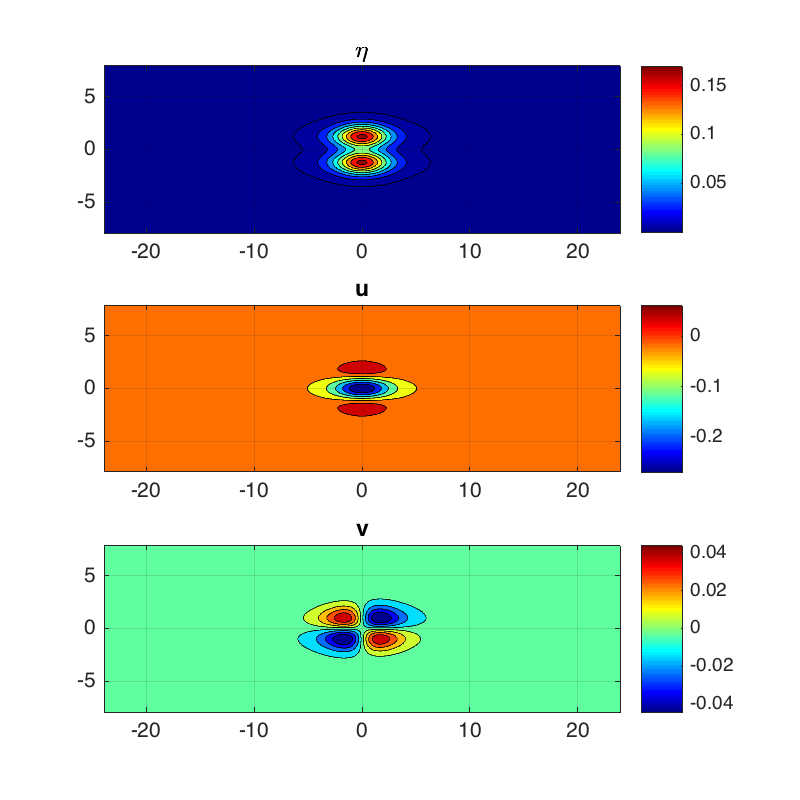

In [4]:
% Initial conditions
u0 = griddata(x_u,y_u,u0,x_eta,y_eta);
v0 = griddata(x_v,y_v,v0,x_eta,y_eta);

% eta 
subplot(3,1,1)
contourf(x_eta,y_eta,eta0,...
        [min(min(min(etas{1}))):0.02:max(max(eta0))]);

colormap('jet')

title(['\eta']);
colorbar
caxis([min(min(eta0)),max(max(eta0))]);    
grid 'on'

% u
subplot(3,1,2)
contourf(x_eta,y_eta,u0,...
        [min(min(u0)):0.05:max(max(u0))]);

colormap('jet')

title(['u']);
colorbar
caxis([min(min(u0)),max(max(u0))]);
grid 'on'

% v
subplot(3,1,3)
contourf(x_eta,y_eta,v0,...
        [min(min(v0)):0.01:max(max(v0))]);

colormap('jet')

title(['v']);
colorbar
caxis([min(min(v0)),max(max(v0))]);
grid 'on'

**Figure 1.** Initial conditions for an Equatorial Rossby Wave soliton. The color scales represent the dimensionless variables. 

#### Mid-stage: t = 20

In [5]:
%plot -s 1400,1200

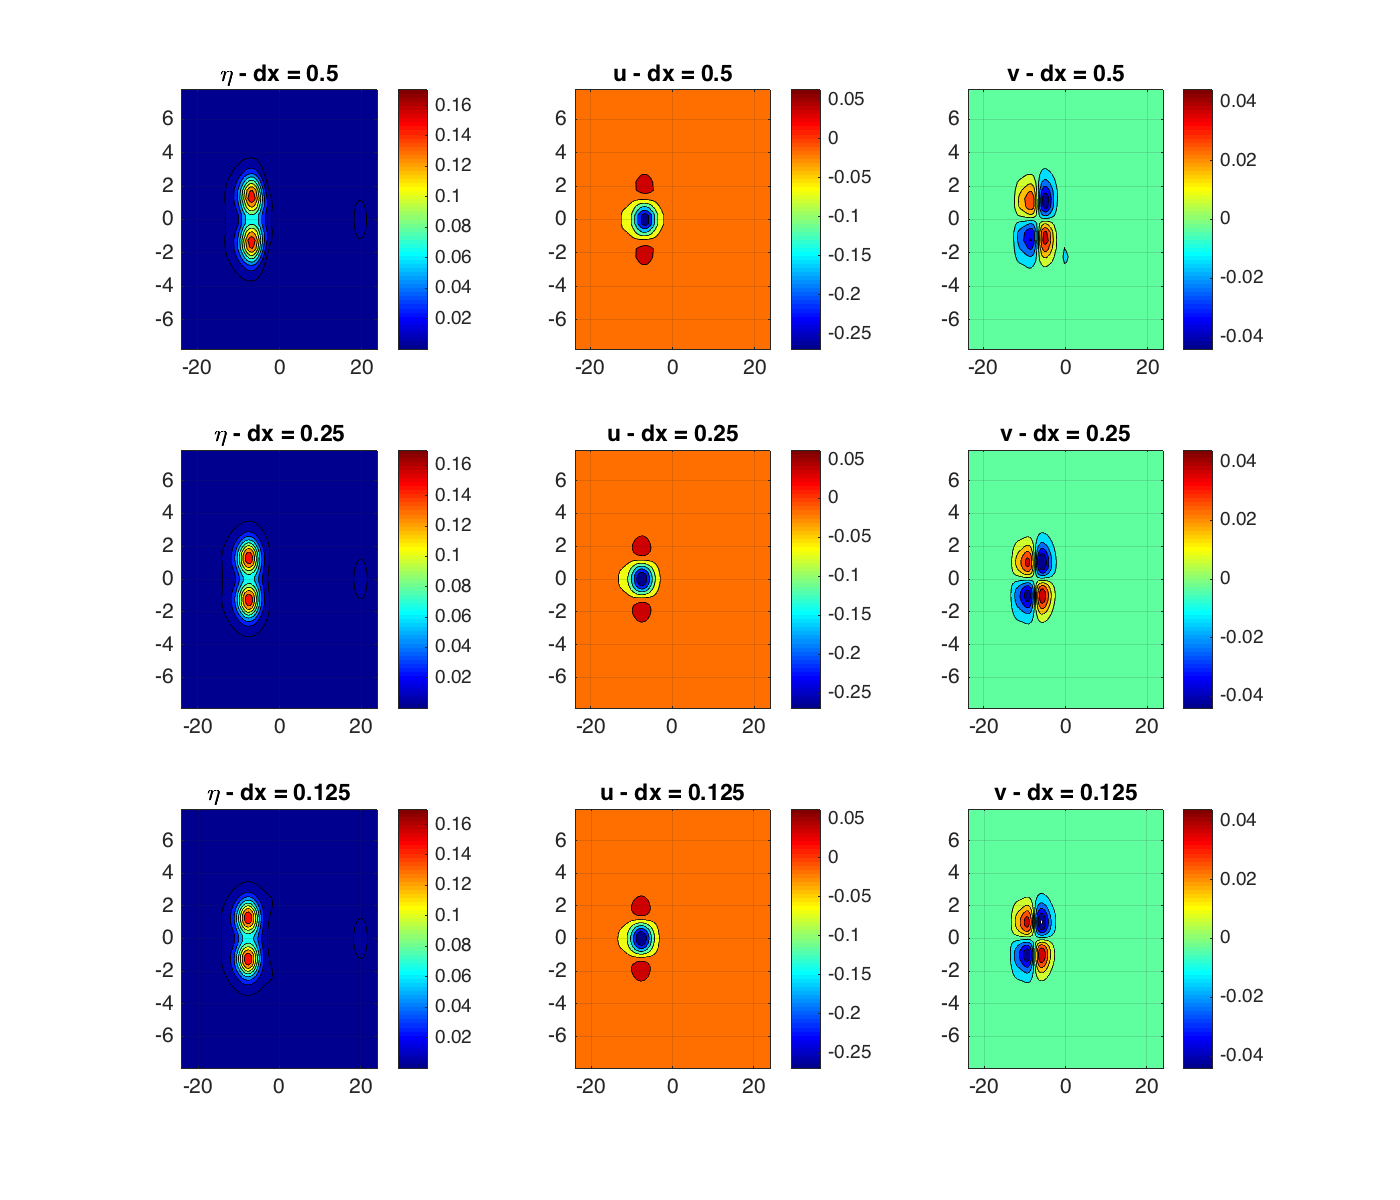

In [6]:
% t = 20
ti = 2;

k = 1;
for i = [1:length(dx)]  
    subplot(3,3,k)

    contourf(xs{i},ys{i},etas{i}(:,:,ti),...
        [min(min(min(etas{1}))):0.02:max(max(eta0))]);

    colormap('jet')
    colorbar
    caxis([min(min(eta0)),max(max(eta0))]);
    grid 'on'

    title(['\eta - dx = ',num2str(dx(i))])
    k = k+1;


    subplot(3,3,k)
    
    contourf(xs{i},ys{i},us{i}(:,:,ti),...
        [min(min(u0)):0.05:max(max(u0))]);

    colormap('jet')
    colorbar
    caxis([min(min(u0)),max(max(u0))]);
    grid 'on'

    title(['u - dx = ',num2str(dx(i))])
    k = k+1;
 
 
 
    subplot(3,3,k)
  
    contourf(xs{i},ys{i},vs{i}(:,:,ti),...
        [min(min(v0)):0.01:max(max(v0))]);

    colormap('jet')
    colorbar
    caxis([min(min(v0)),max(max(v0))]);
    grid 'on'  

    title(['v - dx = ',num2str(dx(i))]) 
    k = k+1;
end

**Figure 2.** Solutions for each numerical experiment ($\Delta x = 0.5, 0.25 \ and \ 0.125$) at $t = 20$. The color scales represent the dimensionless variables. 

**Final Stage: t = 40**

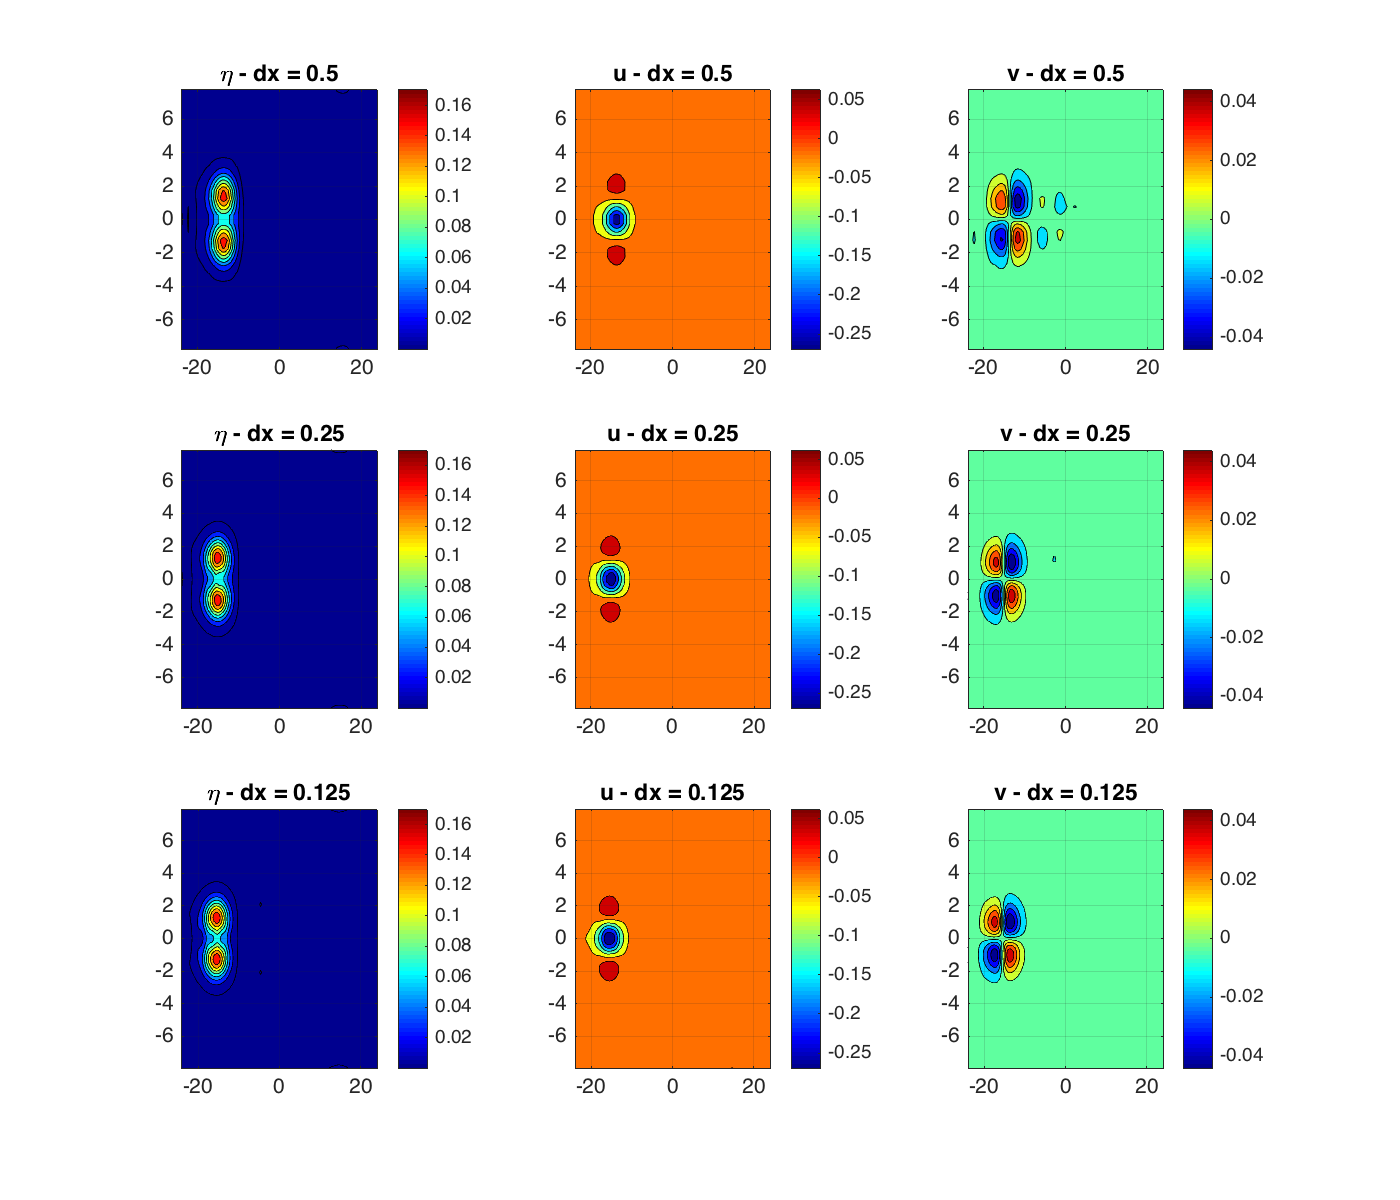

In [7]:
% t = 40
ti = 4;

k = 1;
for i = [1:length(dx)]  
    subplot(3,3,k)

    contourf(xs{i},ys{i},etas{i}(:,:,ti),...
        [min(min(min(etas{1}))):0.02:max(max(eta0))]);

    colormap('jet')
    colorbar
    caxis([min(min(eta0)),max(max(eta0))]);
    grid 'on'

    title(['\eta - dx = ',num2str(dx(i))])
    k = k+1;


    subplot(3,3,k)
    
    contourf(xs{i},ys{i},us{i}(:,:,ti),...
        [min(min(u0)):0.05:max(max(u0))]);

    colormap('jet')
    colorbar
    caxis([min(min(u0)),max(max(u0))]);
    grid 'on'

    title(['u - dx = ',num2str(dx(i))])
    k = k+1;
 
 
 
    subplot(3,3,k)
  
    contourf(xs{i},ys{i},vs{i}(:,:,ti),...
        [min(min(v0)):0.01:max(max(v0))]);

    colormap('jet')
    colorbar
    caxis([min(min(v0)),max(max(v0))]);
    grid 'on'  

    title(['v - dx = ',num2str(dx(i))]) 
    k = k+1;
end

**Figure 3.** Solutions for each numerical experiment ($\Delta x = 0.5, 0.25 \ and \ 0.125$) at $t = 40$. The color scales represent the dimensionless variables. 

From the numerical solutions shown above, the Rossby Wave solion propagates westward with velocities slightly higher in the high resolution case (i. e., $\Delta x = 0.125$). Note that, the solutions for $\Delta x = 0.5$ present some numerical abnormalities related to the resolution and numerical dissipation (e. g. right upper panels from Figures 2 and 3).